<a id='top'></a>
# Analys av COVID-19 i Sverige

All data kommer från [Folkhälsomyndigheten](https://www.folkhalsomyndigheten.se/smittskydd-beredskap/utbrott/aktuella-utbrott/covid-19/bekraftade-fall-i-sverige/).

Folkhälsomyndigheten visar sin statistik [här](https://experience.arcgis.com/experience/09f821667ce64bf7be6f9f87457ed9aa).

### Innehållsförteckning
1. [Antal fall över tid](#antal_fall_över_tid)
2. [Fördelning av sjukdomsfall](#sjukdomsutfall)
3. [Avlidna vs antal fall](#scatter)
4. [Pandemiutveckling](#trajectory)
5. [SIR model](#sir)
6. [Underrapportering - UK](#underrapportering_uk)
7. [Underrapportering - Sverige](#underrapportering_se)

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import xlrd
%matplotlib inline

df = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx")
dfi = df.set_index('Statistikdatum')

df_region = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=3, index_col='Region')
df_region['Population'] = df_region['Totalt_antal_fall']/df_region['Fall_per_100000_inv']
df_region['Intensivvårdade_per_100000_inv'] = df_region['Totalt_antal_intensivvårdade']/df_region['Population']
df_region['Avlidna_per_100000_inv'] = df_region['Totalt_antal_avlidna']/df_region['Population']


<a id='antal_fall_över_tid'></a>
## Antal fall över tid

[Tillbaka till början](#top)

Text(0.06, 0.5, 'Cummulative number of cases')

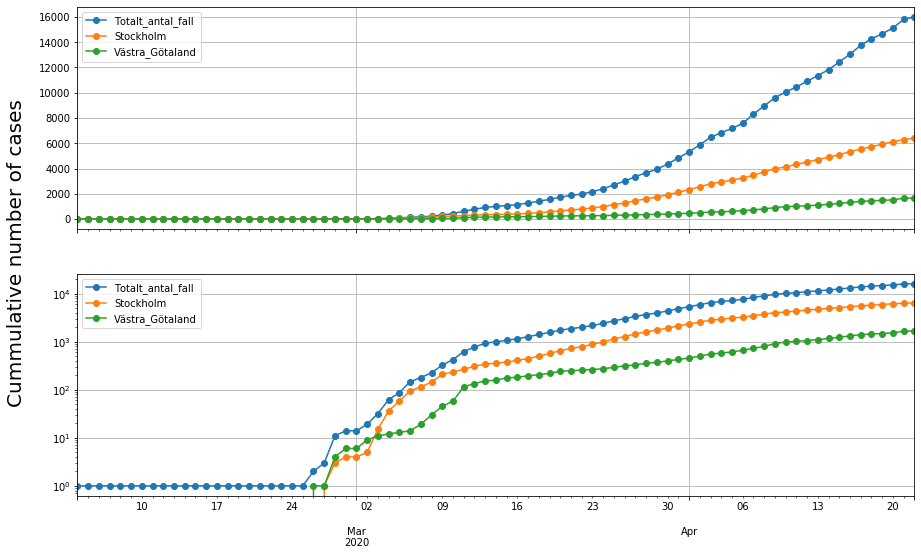

In [2]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))

y = [
    'Totalt_antal_fall',
    'Stockholm',
    'Västra_Götaland',
#     'Sörmland',
]
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=False, ax=ax1)
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=True, ax=ax2)

ax2.set_xlabel('')
fig.text(0.06, 0.5, 'Cummulative number of cases', va='center', rotation='vertical', fontsize=20)

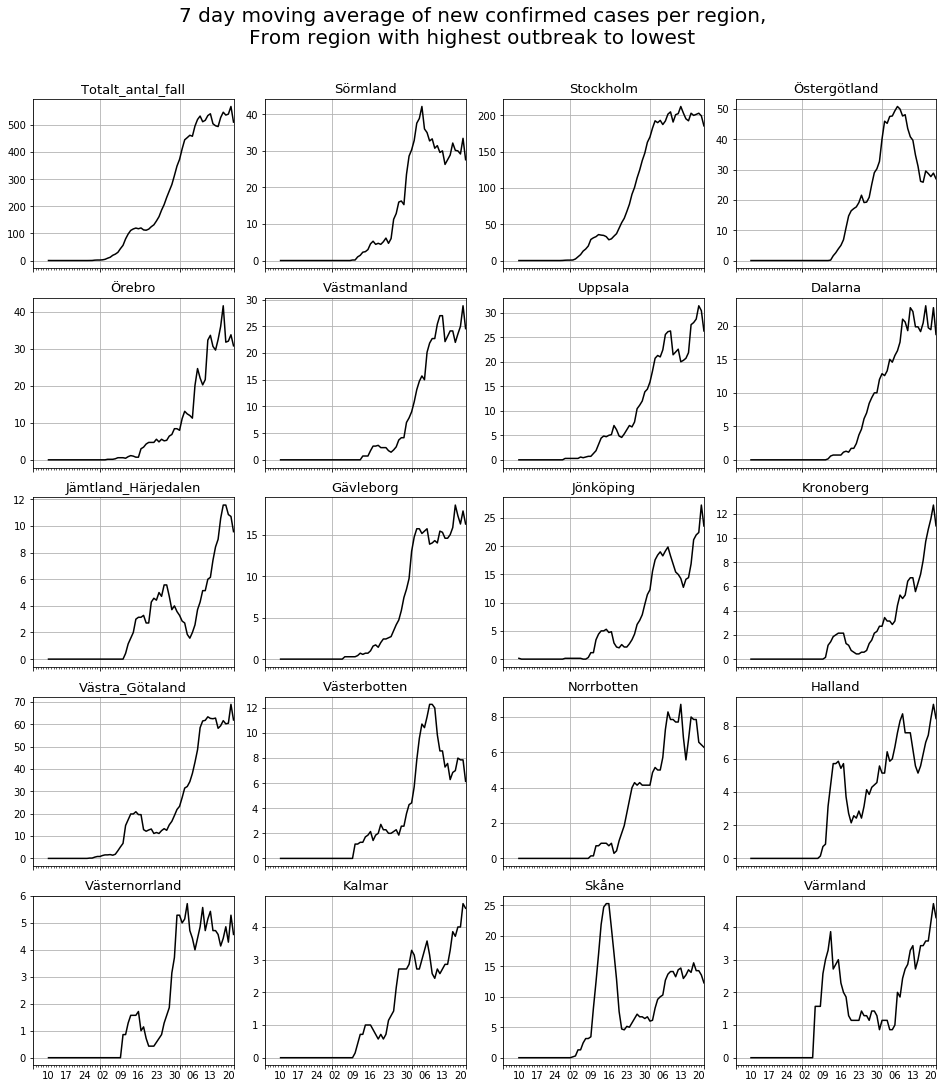

In [3]:
regions = [
    "Totalt_antal_fall",
    "Blekinge",
    "Dalarna",
    "Gotland",
    "Gävleborg",
    "Halland",
    "Jämtland_Härjedalen",
    "Jönköping",
    "Kalmar",
    "Kronoberg",
    "Norrbotten",
    "Skåne",
    "Stockholm",
    "Sörmland",
    "Uppsala",
    "Värmland",
    "Västerbotten",
    "Västernorrland",
    "Västmanland",
    "Västra_Götaland",
    "Örebro",
    "Östergötland"]


sorted_regions = list(df_region.Fall_per_100000_inv.sort_values(ascending=False).index)
sorted_regions = [i.replace(' ', '_') for i in sorted_regions]
sorted_regions.insert(0, 'Totalt_antal_fall')
for region in sorted_regions:
    if region not in regions:
        sorted_regions.remove(region)

    
nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13,15), constrained_layout=True, sharex=True)
axes = np.reshape(axes, -1)

window = 7
fig.suptitle(f'{window} day moving average of new confirmed cases per region,\nFrom region with highest outbreak to lowest\n', fontsize=20)
for region, ax in zip(sorted_regions, axes):
    df_temp = dfi[region].rolling(window).mean()
    df_temp.plot(grid=True, ax=ax, color='k')
    ax.set_title(region, fontsize=13)
    
    ax.set_xlabel('')
    ax.set_xticklabels('')


<a id='sjukdomsutfall'></a>
## Fördelning av sjukdomsutfall

[Tillbaka till början](#top)

Text(0.5, 1.0, 'Numbers per 100000 people and region, sorted on confirmed cases')

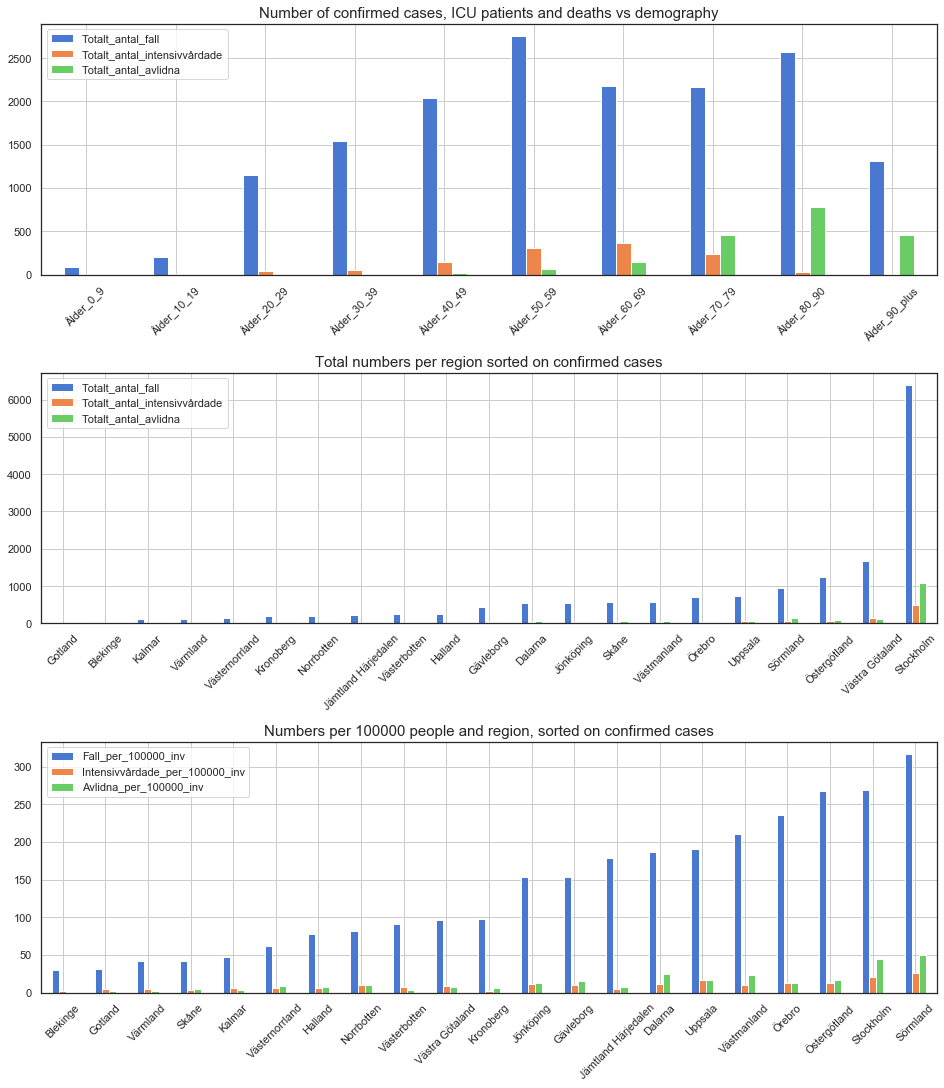

In [4]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

df_age = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=5)
df_age = df_age.iloc[:-1]
df_age.set_index('Åldersgrupp', inplace=True)



fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(13,15))

df_age.plot(kind='bar', grid=True, ax=ax1, rot=45)
ax1.set_title('Number of confirmed cases, ICU patients and deaths vs demography', fontsize=15)
ax1.set_xlabel('')

df_region.sort_values(by=['Totalt_antal_fall']).plot.bar(y=['Totalt_antal_fall', 'Totalt_antal_intensivvårdade', 'Totalt_antal_avlidna'], grid=True, ax=ax2, rot=45)
ax2.set_xlabel('')
ax2.set_title('Total numbers per region sorted on confirmed cases', fontsize=15)

df_region.sort_values(by=['Fall_per_100000_inv']).plot.bar(y=['Fall_per_100000_inv', 'Intensivvårdade_per_100000_inv', 'Avlidna_per_100000_inv'], grid=True, ax=ax3, rot=45)
ax3.set_xlabel('')
ax3.set_title('Numbers per 100000 people and region, sorted on confirmed cases', fontsize=15)

Text(0.5, 0, '')

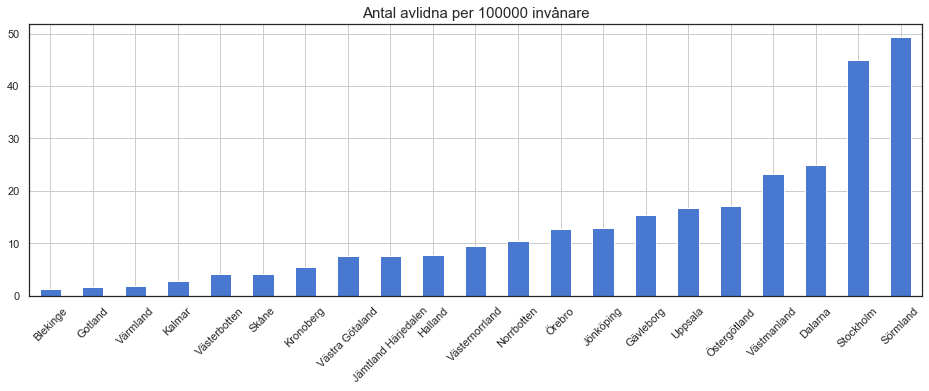

In [5]:
df_avlidna = df_region['Totalt_antal_avlidna']*df_region['Fall_per_100000_inv']/df_region['Totalt_antal_fall']
df_avlidna.name = 'Avlidna_per_100000_inv'
df_avlidna.head()
ax = df_avlidna.sort_values().plot(kind='bar', grid=True, figsize=(16,5), rot=45)
ax.set_title('Antal avlidna per 100000 invånare', fontsize=15)
ax.set_xlabel('')

<a id='scatter'></a>
## Avlidna vs antal fall

[Tillbaka till början](#top)

Text(0.5, 0, 'Total confirmed cases')

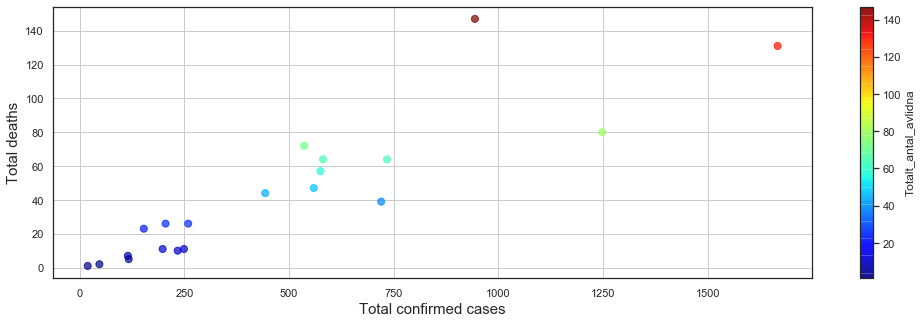

In [6]:
fig, ax = plt.subplots(figsize=(17,5))
plot_kwargs = {
    'grid': True,
    's': 50,
    'alpha': 0.7,
    'c': 'Totalt_antal_avlidna',
    'colormap': 'jet', 
    'ax': ax,}

df_region.drop('Stockholm', axis=0).plot.scatter(x='Totalt_antal_fall', y='Totalt_antal_avlidna', **plot_kwargs)
ax.set_ylabel('Total deaths', fontsize=15)
ax.set_xlabel('Total confirmed cases', fontsize=15)

<a id='trajectory'></a>
## Pandemiutveckling

Denna beräkningen är tagen från youtubekanalen [minutephysics](https://www.youtube.com/watch?v=54XLXg4fYsc)

[Tillbaka till början](#top)

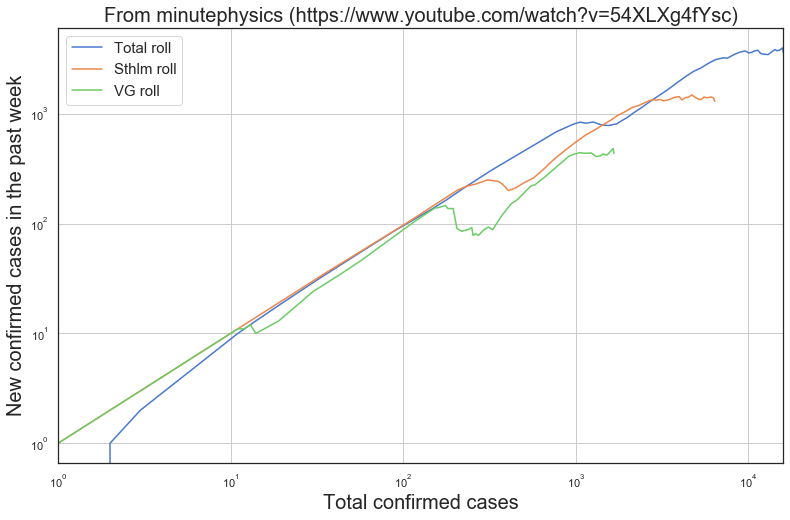

In [261]:
minutephysics = "https://www.youtube.com/watch?v=54XLXg4fYsc"
cols = ['Totalt_antal_fall', 'Stockholm', 'Västra_Götaland']
df_mp = df[cols]
df_mp.loc[:,'sthlm_roll'] = df_mp['Stockholm'].rolling(7).sum()
df_tmp = df_mp[cols].rolling(7).sum()
df_tmp.columns = ['Total roll', 'Sthlm roll', 'VG roll']
df_roll = pd.concat([df_mp.cumsum(), df_tmp], axis=1, sort=False)

fig, ax = plt.subplots(figsize=(13,8))
df_roll.plot(x='Totalt_antal_fall', y='Total roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Stockholm', y='Sthlm roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Västra_Götaland', y='VG roll', grid=True, loglog=True, ax=ax)

ax.set_ylabel('New confirmed cases in the past week', fontsize=20)
ax.set_xlabel('Total confirmed cases', fontsize=20)
ax.set_title(f"From minutephysics ({minutephysics})", fontsize=20)
ax.legend(fontsize=15)


<a id='sir'></a>
## SIR model

[Tillbaka till början](#top)

Text(0.5, 1.0, 'Effective reproduction number, R')

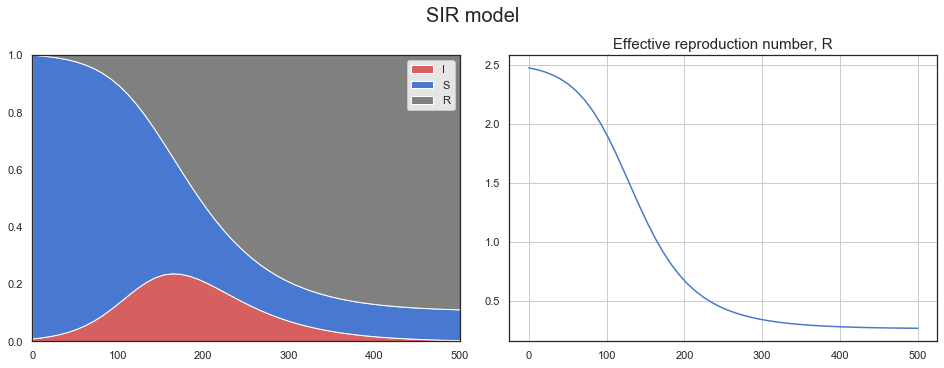

In [51]:

def de_system(y, t, N, r_I, r_R):
    S, I, R = y[0], y[1], y[2]
    
    dS = -r_I*I*S/N
    dI = r_I*I*S/N - r_R*I
    dR = r_R*I
    
    return [dS, dI, dR]

r_eff = 1
r0 = 2.5
r_I = 0.05
r_R = r_I/r0

N = 1
S0 = 0.99*N
I0 = (N-S0)
R0 = 0
y0 = [S0, I0, R0]
t_max = 500
t = np.linspace(0, t_max)

soln = odeint(de_system, y0, t, args=(N, r_I, r_R))
S, I, R = soln[:,0], soln[:,1], soln[:,2]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,5), constrained_layout=True)
fig.suptitle('SIR model', fontsize=20)

ax1.stackplot(t, [I,S,R], labels=['I','S','R'], colors=['r', 'b', 'gray'])
ax1.legend()
ax1.axis([0, t_max, 0, N])


r = (r_I*S*I/N)/(r_R*I)
ax2.plot(t,r)
ax2.grid()
ax2.set_title('Effective reproduction number, R', fontsize=15)

<a id='underrapportering_uk'></a>
## Underrapportering - UK


[Tillbaka till början](#top)

Text(0.5, 1.0, '2020 excess deaths - reported corona deaths')

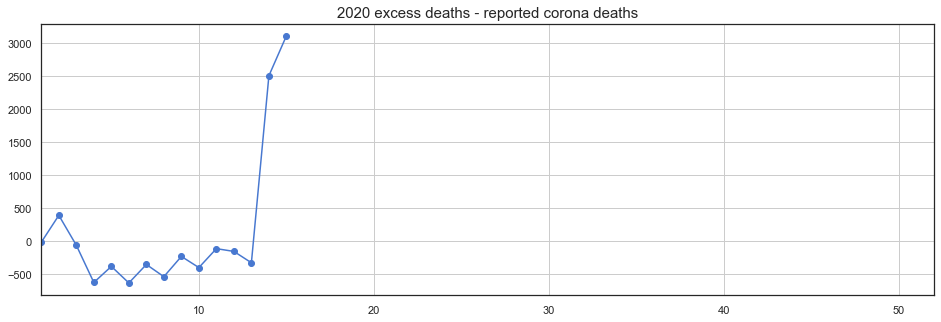

In [147]:
df_uk = pd.read_excel('weekly_deaths_uk_2019.xlsx').transpose()
# df_uk_cumsum = df_uk.cumsum()
df_uk.columns = ['weekly_2019', 'weekly_2020', 'daily_covid19_deaths']

weekly_corona = [0]*9
weekly_corona.extend(df_uk.daily_covid19_deaths.fillna(0).to_numpy()[:-3].reshape(-1,7).sum(axis=1).tolist())
weekly_corona.extend([np.nan]*(52-len(weekly_corona)))
df_uk['weekly_covid19'] = weekly_corona
df_uk.drop('daily_covid19_deaths', axis=1, inplace=True)

df_uk['Total_death_diff'] = df_uk['weekly_2020'] - df_uk['weekly_2019']

df_uk['Excessive_deaths'] = df_uk['Total_death_diff'] - df_uk['weekly_covid19']

fig, ax = plt.subplots(figsize=(16,5))
df_uk.plot(y=['Excessive_deaths'], grid=True, marker='o', ax=ax, legend=False)
ax.set_title('2020 excess deaths - reported corona deaths', fontsize=15)

<a id='underrapportering_se'></a>
## Underrapportering - Sverige

Statistik över totalt antal döda hämtas från [SCB](https://scb.se/hitta-statistik/statistik-efter-amne/befolkning/befolkningens-sammansattning/befolkningsstatistik/) (Preliminär statistik över döda).

Se även [New York Times](https://www.nytimes.com/interactive/2020/04/21/world/coronavirus-missing-deaths.html) artikel.

[Tillbaka till början](#top)

Text(0.5, 1.0, 'Cumulative difference between the number of deaths 2020, without reported Covid-19 deaths, and previous years')

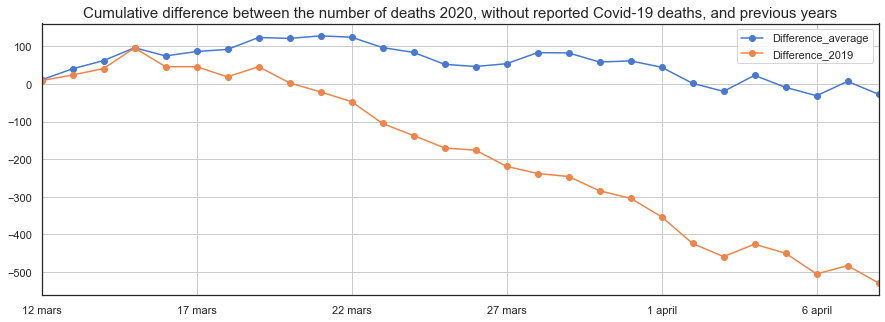

In [314]:
workbook = xlrd.open_workbook('2020-04-17---preliminar-statistik-over-doda-inkl-eng.xlsx', on_demand=True)
worksheet = workbook.sheet_by_name('Tabell 1')
df_2020_deaths = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=1, usecols="B")

dates = worksheet.col_values(0,7,373)
deaths_avg = worksheet.col_values(7, 7, 373)
deaths_2019 = worksheet.col_values(5, 7, 373)
deaths_2020 = worksheet.col_values(6, 7, 373)
df_sweden = pd.DataFrame({'Deaths_average': deaths_avg, 'Deaths_2020': deaths_2020, 'Deaths_2019': deaths_2019}, index=dates)
df_sweden.drop(['29 februari'], inplace=True)

df_sweden['Excess_deaths_average'] = df_sweden['Deaths_2020'] - df_sweden['Deaths_average']
df_sweden['Excess_deaths_2019'] = df_sweden['Deaths_2020'] - df_sweden['Deaths_2019']

list_2020_deaths = df_2020_deaths['Antal_avlidna'].to_list()
df_sweden['Corona_deaths'] = 0
index_first_death = 70
index_last_day = index_first_death+len(list_2020_deaths)
df_sweden.iloc[index_first_death:index_last_day,5] = list_2020_deaths

df_sweden['Difference_average'] = df_sweden['Corona_deaths'] - df_sweden['Excess_deaths_average']
df_sweden['Difference_2019'] = df_sweden['Corona_deaths'] - df_sweden['Excess_deaths_2019']

fig, ax = plt.subplots(figsize=(15,5))
last_reliable_day = min(index_last_day, deaths_2020.index(0))-10
df_sweden.iloc[index_first_death:last_reliable_day,:].cumsum().plot(y=['Difference_average', 'Difference_2019'], grid=True, legend=True, marker='o', ax=ax)
ax.set_title('Cumulative difference between the number of deaths 2020, without reported Covid-19 deaths, and previous years', fontsize=15)


Text(0.5, 1.0, 'Number of deaths 2020, 2019 and average between 2015-2019')

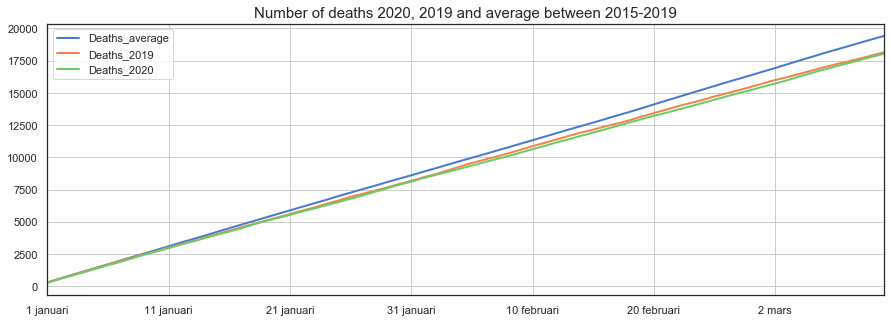

In [320]:
fig, ax = plt.subplots()
kwargs = {'grid': True, 'lw':2, 'figsize': (15,5), 'ax': ax}

df_sweden.iloc[:index_first_death,:].cumsum().plot(y=['Deaths_average', 'Deaths_2019', 'Deaths_2020'], **kwargs)
ax.set_title('Number of deaths 2020, 2019 and average between 2015-2019', fontsize=15)